In [27]:
import numpy as np
import pandas as pd
from openbb import obb
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt 

In [29]:
obb.user.preferences.output_type = "dataframe"

In [31]:
# Loading data from a portfolio of mining and health care companies. 
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK", "SPY"]

# Create an object called data then use to get the prices of each stock
data = obb.equity.price.historical(
    symbols,
    start_date="2022-01-01",
    end_date="2024-12-31",
    provider="yfinance"
).pivot(columns="symbol", values="close")

In [33]:
# Calculate the daily returns of each stock in the portfolio, purposely excludeding SPY
# because we beta of the portfolio returns
benchmark_returns = (
    data
    .pop("SPY")
    .pct_change()
    .dropna()
)

In [35]:
# Calculate the returns for the entire portfolio
portfolio_returns = (
    data
    .pct_change()
    .dropna()
    .sum(axis=1)
)

In [37]:
# Set the name property on the series for plotting purposes
portfolio_returns.name = "portfolio"

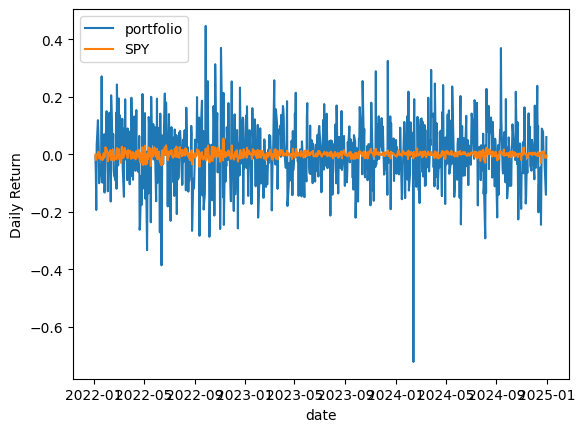

In [39]:
# Plot the portfolio returns and the benchmark returns to visualize the difference
portfolio_returns.plot()
benchmark_returns.plot()
plt.ylabel("Daily Return")
plt.legend()

In [45]:
# A function that returns the alpha and beta coefficients from a linear regression
X = benchmark_returns.values
Y = portfolio_returns.values
def linreg(x, y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    x = x[:, 1]
    return model.params[0], model.params[1]

In [49]:
# Calculate the alpha and beta coefficients from the regression between the portfolio & benchmark returns
alpha, beta = linreg(X, Y)
print(f"Alpha: {alpha}")
print(f"Beta: {beta}")

Alpha: 0.0010764160846646175
Beta: 4.738654565053885


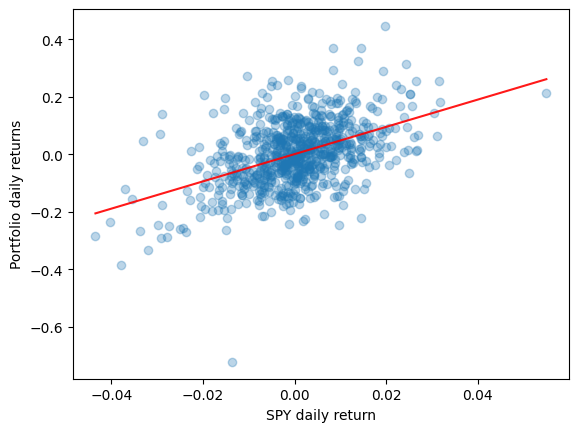

In [53]:
# A scatter plot that visulizes the linear relationship between the portfolio & benchmark returns
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha
plt.scatter(X, Y, alpha=0.3)
plt.xlabel("SPY daily return")
plt.ylabel("Portfolio daily returns")
plt.plot(X2, Y_hat, "r", alpha=0.9)

In [55]:
# A time series of portfolio returns including the beta hedge
hedged_portfolio_returns = -1 * beta * benchmark_returns + portfolio_returns

In [63]:
# Rerun the regression to see the beta
P = hedged_portfolio_returns.values
_, beta = linreg(X, P)
print(f"Beta: {beta}")

Beta: 1.4155343563970746e-15


In [65]:
# Calculates the information ratio which is a measure used to evaluate the risk-adjusted performance
# of a trading strategy
def information_ratio(portfolio_returns, benchmark_returns):
    active_return = portfolio_returns - benchmark_returns
    tracking_error = active_return.std()
    return active_return.mean() / tracking_error

In [ ]:
# Use the information ratio function to compare the differences between our hedged and unhedged portfolios
hedged_ir = information_ratio(
    hedged_portfolio_returns,
    benchmark_returns
)
un